# Q1 Vanilla VAE

## Imports

In [1]:

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
from datasets import load_dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pytorch_fid import fid_score
from torchvision.utils import save_image
import torch.nn.functional as F
import torchvision.utils as vutils
import random

## Butterfly dataset

In [2]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_filepath=r"/home/sriyar/ADRL_Assignment2/butterflies_data/2/Training_set.csv" 
dataset_filepath_test=r"/home/sriyar/ADRL_Assignment2/butterflies_data/2/Testing_set.csv" 

data_transforms = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor() ,
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[1, 1, 1])  
])

dataset_train = load_dataset('csv', data_files=dataset_filepath)
dataset_test = load_dataset('csv', data_files=dataset_filepath_test)


# Function transform the image
def transform_image_train(data):
    image = Image.open('/home/sriyar/ADRL_Assignment2/butterflies_data/2/train/'+data['filename'])
    data['image'] = data_transforms(image)
    return data
# Function transform the image
def transform_image_test(data):
    image = Image.open('/home/sriyar/ADRL_Assignment2/butterflies_data/2/test/'+data['filename'])
    data['image'] = data_transforms(image)
    return data
dataset_train = dataset_train.map(transform_image_train)
dataset_test = dataset_test.map(transform_image_test)
dataset_train.set_format(type='torch', columns=['image'])
print(dataset_train)
dataset_test.set_format(type='torch', columns=['image'])
print(dataset_test)

dataloader_butterfly_train = DataLoader(dataset_train['train'], batch_size=64, shuffle=True, num_workers=5)
dataloader_butterfly_test = DataLoader(dataset_test['train'], batch_size=64, shuffle=True, num_workers=5)



Map:   0%|          | 0/6499 [00:00<?, ? examples/s]

Map:   0%|          | 0/2786 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['filename', 'label', 'image'],
        num_rows: 6499
    })
})
DatasetDict({
    train: Dataset({
        features: ['filename', 'image'],
        num_rows: 2786
    })
})


In [3]:


import torch
from torch import nn
from torch.nn import functional as F


class VAE(nn.Module):
    def __init__(self, zsize, layer_count=3, channels=3):
        super(VAE, self).__init__()

        d = 128
        self.d = d
        self.zsize = zsize

        self.layer_count = layer_count

        mul = 1
        inputs = channels
        for i in range(self.layer_count):
            setattr(self, "conv%d" % (i + 1), nn.Conv2d(inputs, d * mul, 4, 2, 1))
            setattr(self, "conv%d_bn" % (i + 1), nn.BatchNorm2d(d * mul))
            inputs = d * mul
            mul *= 2

        self.d_max = inputs

        self.fc1 = nn.Linear(inputs * 4 * 4, zsize)
        self.fc2 = nn.Linear(inputs * 4 * 4, zsize)

        self.d1 = nn.Linear(zsize, inputs * 4 * 4)

        mul = inputs // d // 2

        for i in range(1, self.layer_count):
            setattr(self, "deconv%d" % (i + 1), nn.ConvTranspose2d(inputs, d * mul, 4, 2, 1))
            setattr(self, "deconv%d_bn" % (i + 1), nn.BatchNorm2d(d * mul))
            inputs = d * mul
            mul //= 2

        setattr(self, "deconv%d" % (self.layer_count + 1), nn.ConvTranspose2d(inputs, channels, 4, 2, 1))

    def encode(self, x):
        for i in range(self.layer_count):
            x = F.relu(getattr(self, "conv%d_bn" % (i + 1))(getattr(self, "conv%d" % (i + 1))(x)))

        x = x.view(x.shape[0], self.d_max * 4 * 4)
        h1 = self.fc1(x)
        h2 = self.fc2(x)
        return h1, h2

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, x):
        x = x.view(x.shape[0], self.zsize)
        x = self.d1(x)
        x = x.view(x.shape[0], self.d_max, 4, 4)
        #x = self.deconv1_bn(x)
        x = F.leaky_relu(x, 0.2)

        for i in range(1, self.layer_count):
            x = F.leaky_relu(getattr(self, "deconv%d_bn" % (i + 1))(getattr(self, "deconv%d" % (i + 1))(x)), 0.2)

        x = F.tanh(getattr(self, "deconv%d" % (self.layer_count + 1))(x))
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        mu = mu.squeeze()
        logvar = logvar.squeeze()
        z = self.reparameterize(mu, logvar)
        return self.decode(z.view(-1, self.zsize, 1, 1)), mu, logvar

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)


def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()


from __future__ import print_function
import torch.utils.data
from scipy import misc
from torch import optim
from torchvision.utils import save_image
import numpy as np
import pickle
import time
import random
import os

im_size = 128


def loss_function(recon_x, x, mu, logvar):
    MSE = torch.mean((recon_x - x)**2)
    KLD = -0.5 * torch.mean(torch.mean(1 + logvar - mu.pow(2) - logvar.exp(), 1))
    return MSE, KLD * 1


os.makedirs('./results_rec', exist_ok=True)
os.makedirs('./results_gen', exist_ok=True)
def main():
    batch_size = 128
    z_size = 512
    vae = VAE(zsize=z_size, layer_count=5)
    vae.cuda()
    vae.train()
    vae.weight_init(mean=0, std=0.02)

    lr = 0.0005
    vae_optimizer = optim.Adam(vae.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=1e-5)
 
    train_epoch = 40

    # Latent vector sample for generating images later
    sample1 = torch.randn(64, z_size).view(-1, z_size, 1, 1).cuda()

    for epoch in range(train_epoch):
        vae.train()

        # Use the butterfly dataloader
        print("Training Epoch: ", epoch + 1)

        rec_loss = 0
        kl_loss = 0
        epoch_start_time = time.time()

        # Adjust learning rate every 8 epochs
        if (epoch + 1) % 8 == 0:
            vae_optimizer.param_groups[0]['lr'] /= 4
            print("Learning rate changed!")

        # Loop through batches of the butterfly training dataset
        i = 0
        for x in dataloader_butterfly_train:
            x = x['image'].cuda()  # Get the image tensor
            vae.train()
            vae.zero_grad()

            # Forward pass
            rec, mu, logvar = vae(x)

            # Compute the loss
            loss_re, loss_kl = loss_function(rec, x, mu, logvar)
            (loss_re + loss_kl).backward()
            vae_optimizer.step()

            rec_loss += loss_re.item()
            kl_loss += loss_kl.item()

            # Report losses and save samples every 60 iterations
            i += 1
            if i % 60 == 0:
                rec_loss /= 60
                kl_loss /= 60
                print('\n[%d/%d] - rec loss: %.9f, KL loss: %.9f' % (
                    epoch + 1, train_epoch, rec_loss, kl_loss))
                
                # Reset the loss counters
                rec_loss = 0
                kl_loss = 0

                with torch.no_grad():
                    vae.eval()
                    x_rec, _, _ = vae(x)
                    
                    # Save reconstructed images
                    resultsample = torch.cat([x, x_rec])  + 0.5
                    save_image(resultsample.cpu(), f'./results_rec/sample_{epoch}_{i}.png')

                    # Generate samples from random latent space
                    x_gen = vae.decode(sample1)
                    resultsample = x_gen + 0.5
                    save_image(resultsample.cpu(), f'./results_gen/sample_{epoch}_{i}.png')

        epoch_end_time = time.time()
        print(f"Epoch {epoch+1} completed in {epoch_end_time - epoch_start_time:.2f}s")

    # Save the trained model
    print("Training complete! Saving model...")
    torch.save(vae.state_dict(), "VAEmodel_butterfly.pkl")


if __name__ == '__main__':
    main()


Training Epoch:  1

[1/40] - rec loss: 0.073324643, KL loss: 3.056619539
Epoch 1 completed in 11.92s
Training Epoch:  2

[2/40] - rec loss: 0.061397973, KL loss: 0.163675641
Epoch 2 completed in 11.38s
Training Epoch:  3

[3/40] - rec loss: 0.057966845, KL loss: 0.015971988
Epoch 3 completed in 11.51s
Training Epoch:  4

[4/40] - rec loss: 0.057527360, KL loss: 0.084081392
Epoch 4 completed in 11.51s
Training Epoch:  5

[5/40] - rec loss: 0.055914859, KL loss: 0.018155492
Epoch 5 completed in 11.69s
Training Epoch:  6

[6/40] - rec loss: 0.060918025, KL loss: 12490894187395126.000000000
Epoch 6 completed in 10.98s
Training Epoch:  7

[7/40] - rec loss: 0.067672513, KL loss: 199.348809401
Epoch 7 completed in 10.80s
Training Epoch:  8
Learning rate changed!

[8/40] - rec loss: 0.059079004, KL loss: 7.895214073
Epoch 8 completed in 10.81s
Training Epoch:  9

[9/40] - rec loss: 0.055531657, KL loss: 7.595649354
Epoch 9 completed in 11.78s
Training Epoch:  10

[10/40] - rec loss: 0.0542833

# Loss plots
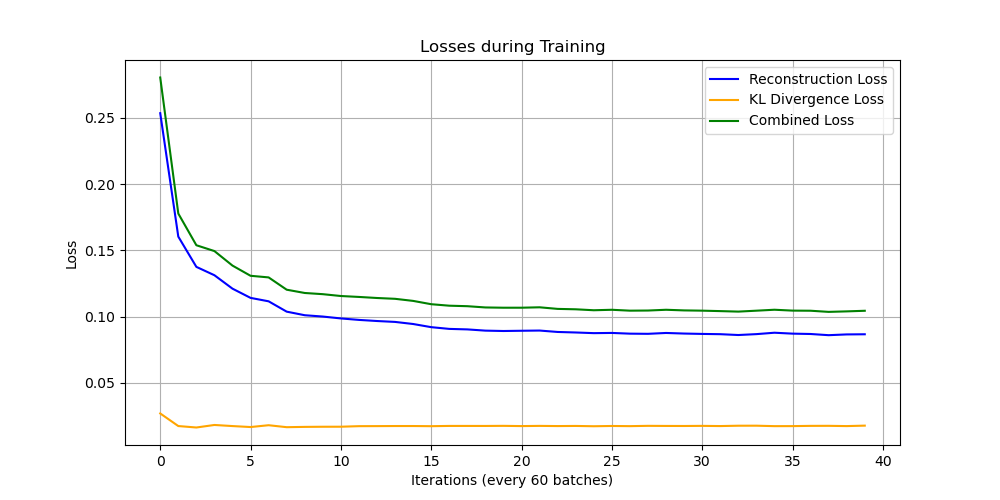


### Generated images

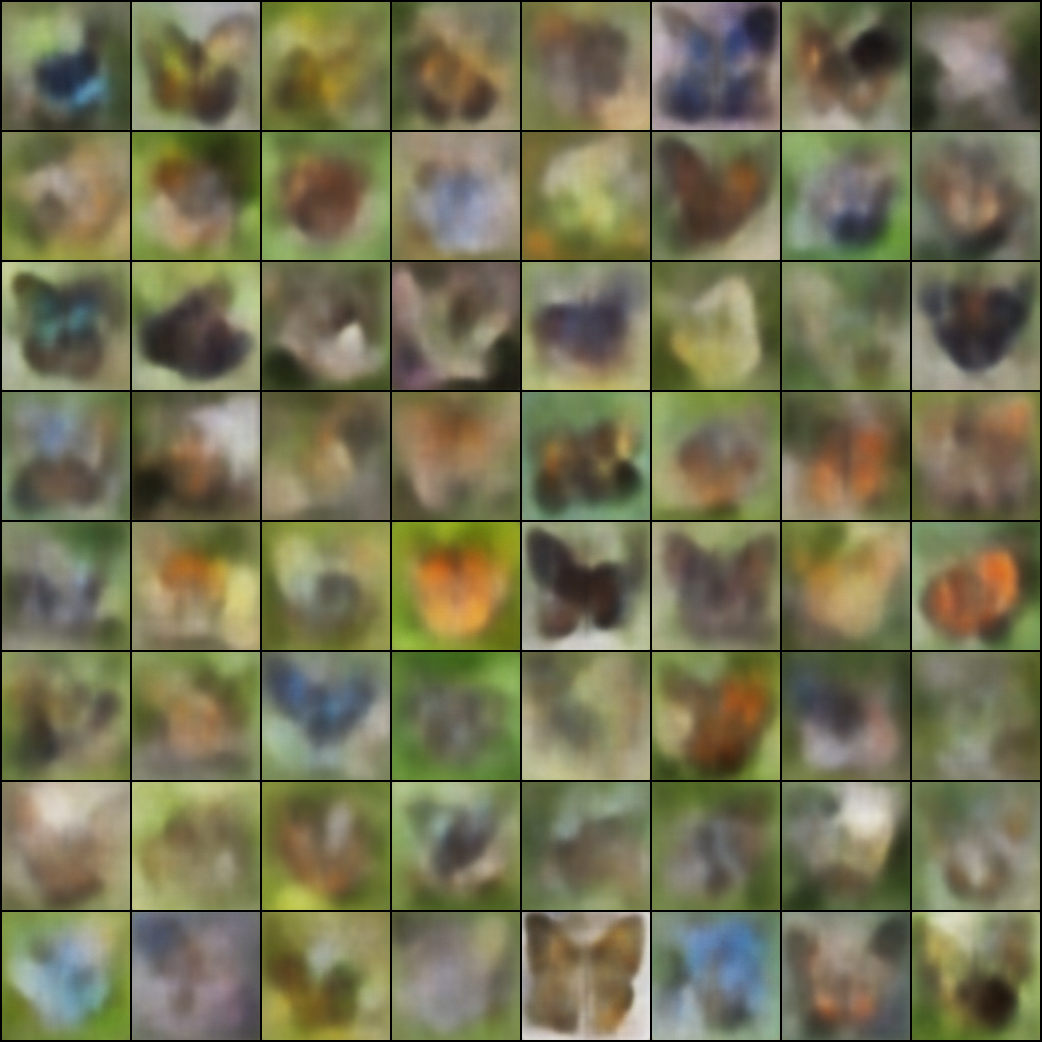